              Datetime   AEP_MW
0  2004-12-31 01:00:00  13478.0
1  2004-12-31 02:00:00  12865.0
2  2004-12-31 03:00:00  12577.0
3  2004-12-31 04:00:00  12517.0
4  2004-12-31 05:00:00  12670.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121273 entries, 0 to 121272
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  121273 non-null  object 
 1   AEP_MW    121273 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.9+ MB
None


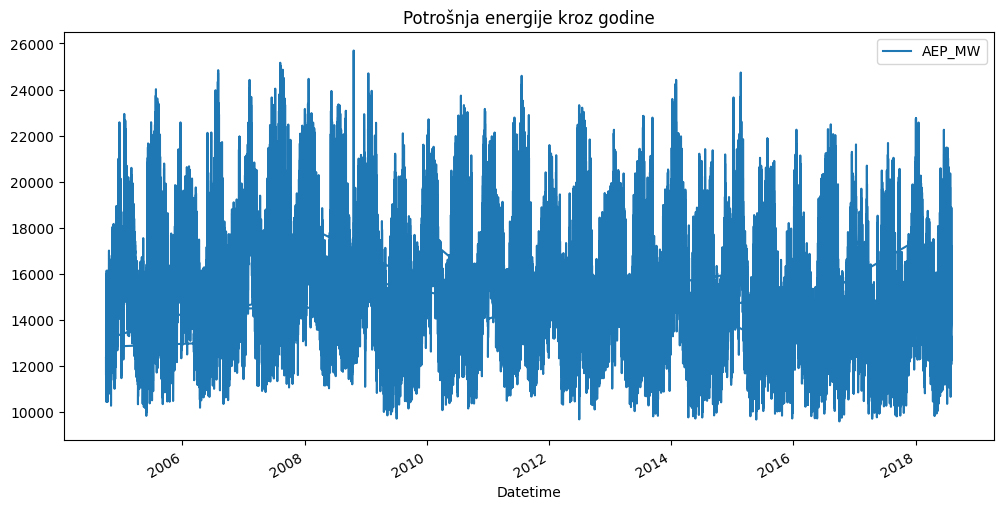

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Učitavanje podataka
df = pd.read_csv('archive/AEP_hourly.csv')

# Pregled prvih 5 redova
print(df.head())

# Provjera tipova podataka
print(df.info())

# Pretvaranje stupca s vremenom u Datetime format
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)

df.plot(figsize=(12,6), title='Potrošnja energije kroz godine')
plt.show()

In [2]:
# Features
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['quarter'] = df.index.quarter
df['month'] = df.index.month
df['year'] = df.index.year
df['dayofyear'] = df.index.dayofyear
df['is_weekend'] = df['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)

print(df.head())

                      AEP_MW  hour  dayofweek  quarter  month  year  \
Datetime                                                              
2004-12-31 01:00:00  13478.0     1          4        4     12  2004   
2004-12-31 02:00:00  12865.0     2          4        4     12  2004   
2004-12-31 03:00:00  12577.0     3          4        4     12  2004   
2004-12-31 04:00:00  12517.0     4          4        4     12  2004   
2004-12-31 05:00:00  12670.0     5          4        4     12  2004   

                     dayofyear  is_weekend  
Datetime                                    
2004-12-31 01:00:00        366           0  
2004-12-31 02:00:00        366           0  
2004-12-31 03:00:00        366           0  
2004-12-31 04:00:00        366           0  
2004-12-31 05:00:00        366           0  


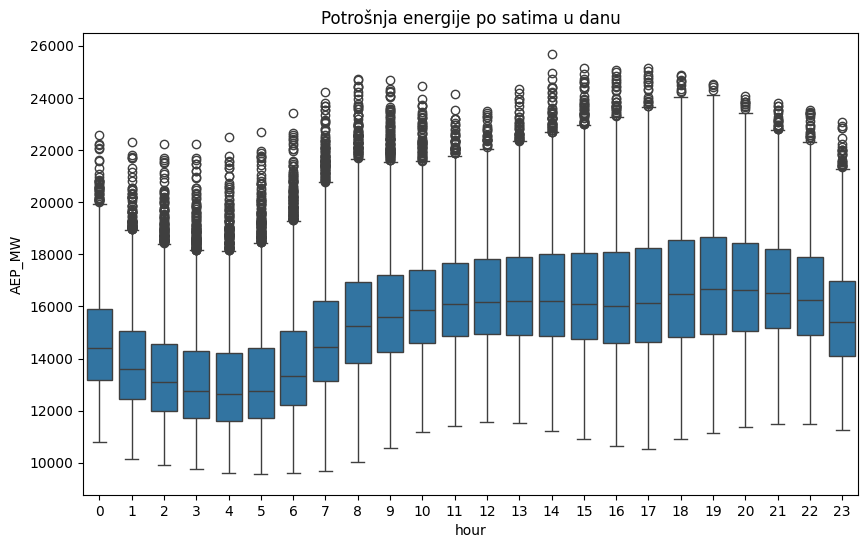

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='hour', y='AEP_MW')
plt.title('Potrošnja energije po satima u danu')
plt.show()

[0]	validation_0-rmse:2557.05852	validation_1-rmse:2669.66874
[100]	validation_0-rmse:1667.99304	validation_1-rmse:1906.43321
[200]	validation_0-rmse:1388.41609	validation_1-rmse:1728.03964
[300]	validation_0-rmse:1260.06288	validation_1-rmse:1670.93868
[400]	validation_0-rmse:1170.54347	validation_1-rmse:1651.83339
[500]	validation_0-rmse:1113.48343	validation_1-rmse:1644.49126
[545]	validation_0-rmse:1091.20163	validation_1-rmse:1647.88201


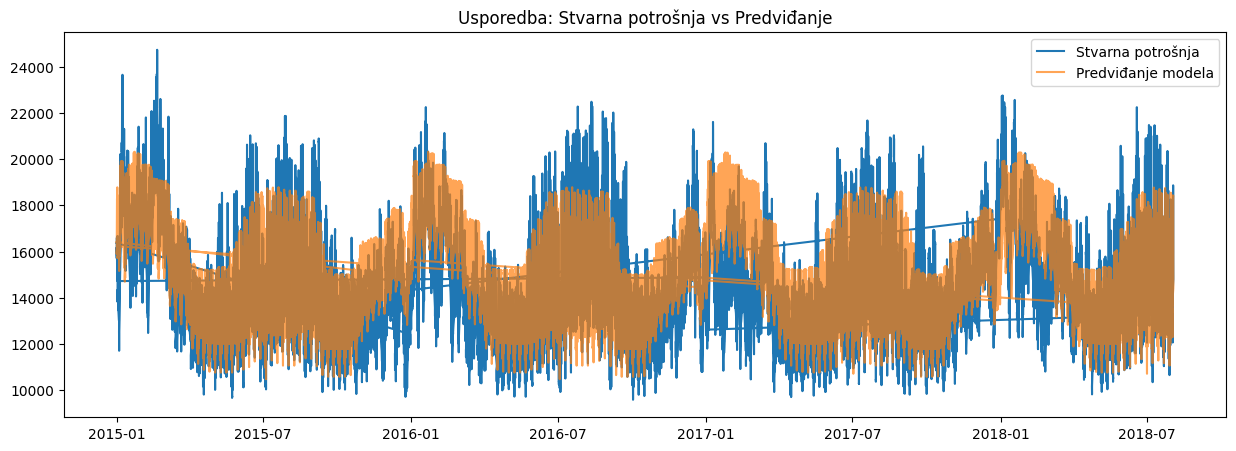

In [4]:
import xgboost as xgb

features = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'is_weekend']
target = 'AEP_MW' 

train = df.loc[df.index < '2015-01-01'].copy()
test = df.loc[df.index >= '2015-01-01'].copy()

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

model = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, learning_rate=0.01)
model.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_test, y_test)],
          verbose=100)


test['prediction'] = model.predict(X_test)

plt.figure(figsize=(15, 5))
plt.plot(test.index, test[target], label='Stvarna potrošnja')
plt.plot(test.index, test['prediction'], label='Predviđanje modela', alpha=0.7)
plt.title('Usporedba: Stvarna potrošnja vs Predviđanje')
plt.legend()
plt.show()

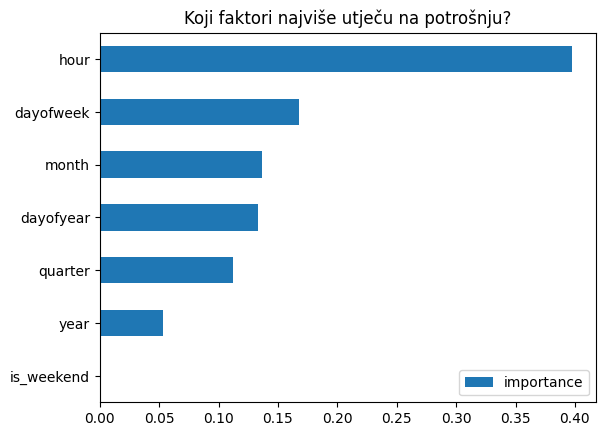

In [8]:
fi = pd.DataFrame(data=model.feature_importances_, index=features, columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Koji faktori najviše utječu na potrošnju?')
plt.legend(loc='lower right')

In [6]:
model.save_model('model.json')
print("Model je spremljen!")

Model je spremljen!


In [7]:
from sklearn.metrics import mean_absolute_percentage_error

mape = mean_absolute_percentage_error(test[target], test['prediction'])
print(f"Srednja apsolutna postotna pogreška (MAPE): {mape * 100:.2f}%")
print(f"Točnost modela: {100 - (mape * 100):.2f}%")

Srednja apsolutna postotna pogreška (MAPE): 8.86%
Točnost modela: 91.14%
